## Open Space Analysis

I was curious to work with public open space data because of the work of the Milton School Building Committee.

In recent public meetings, there has been much discussion of suitable sites in Milton for the construction of a new school.  Because
an RFP for the purchase of a suitable land parcel received no responses, the committee focused on currently open land owned by the Town of Milton,
restricting its searches to parcels of 6 acres or more.  It should be possible to identify all such parcels using the public open space dataset.

Additionally, Milton is famous for its extensive forests and trails, being nestled within the Blue Hills reservation.  I wanted to see if
this qualitative feature of life in Milton could be shown quantitatively in the open space data.  To achieve this, I compare the average
distance to the nearest open space parcel for residential land parcels in Milton vs Quincy, our significantly larger and more urban neighbor.  I wanted
to see if the average residential parcel is closer to open space in Milton than in Quincy.

In [1]:
import geopandas as gpd
import folium
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

import milton_maps as mm

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_context("notebook")

/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/milton-maps-gfMaDXEA-py3.10/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### Load cleaned and processed input files

This notebook works from cleaned and transformed data.  The transformation pipeline is defined in `dvc.yaml`.  To simply work with the latest version, pull the appropriate versions from dvc using `dvc pull`.  To regenerate the files, perhaps with local code changes, run `dvc repro`.

In [2]:
town_boundaries = gpd.read_file("../data/processed/town_boundaries.shp.zip").set_index("TOWN_ID")
milton_quincy_boundaries = town_boundaries[town_boundaries.TOWN.isin(["MILTON", "QUINCY"])]
milton_quincy_boundaries.shape

(2, 19)

In [3]:
openspace = gpd.read_file("../data/processed/openspace.shp.zip", mask=milton_quincy_boundaries)
openspace.shape

(767, 62)

In [4]:
residential_tax_parcels = joblib.load("../data/processed/residential_tax_parcels.pkl")
residential_tax_parcels.shape

(32387, 28)

### Data review

In order to contextualize the open space data maps, we'll plot them on top of the town boundary shapes for Milton and Quincy.  Load the town boundary data:

/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/milton-maps-gfMaDXEA-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/milton-maps-gfMaDXEA-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/milton-maps-gfMaDXEA-py3.10/lib/python3.10/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/alexhasha/Library/Caches/pypoetry/virtualen

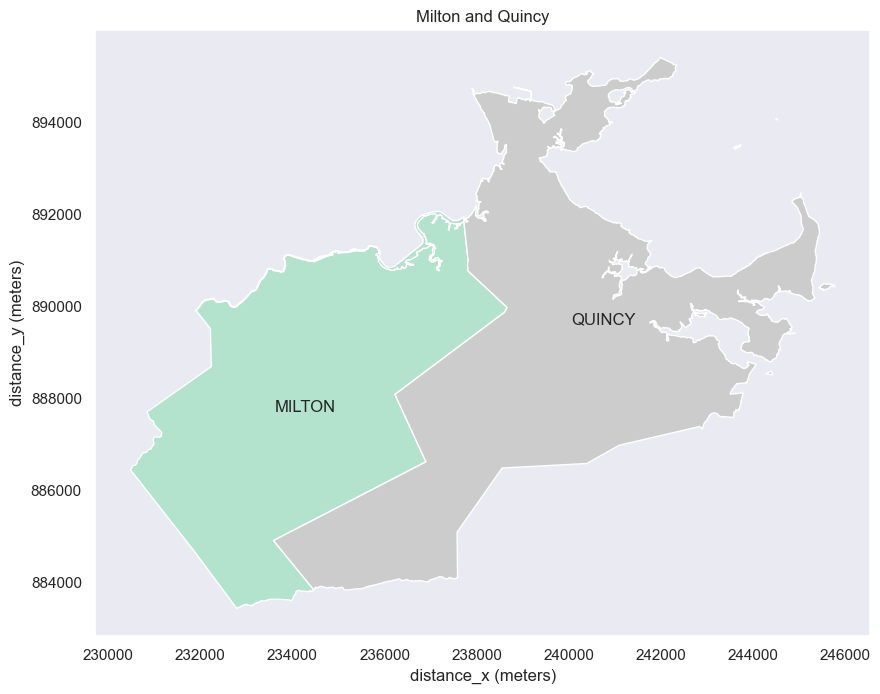

In [5]:
fig, ax = plt.subplots(1, figsize=(10,10))
mm.plot_map(milton_quincy_boundaries,
                 column="TOWN",
                 cmap="Pastel2",
                 title="Milton and Quincy",
                 legend=False,
                 ax=ax)
for i in milton_quincy_boundaries.index:
    x = town_boundaries.loc[[i]].representative_point().x
    y = town_boundaries.loc[[i]].representative_point().y
    plt.annotate(town_boundaries.loc[i, "TOWN"], (x,y))

plt.show()

#### Open space maps

Let's get a quick visualization of open spaces on our map of Milton and Quincy.  The following plot color codes the open spaces by the name of its
Manager.

/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/milton-maps-gfMaDXEA-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/milton-maps-gfMaDXEA-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/milton-maps-gfMaDXEA-py3.10/lib/python3.10/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/alexhasha/Library/Caches/pypoetry/virtualen

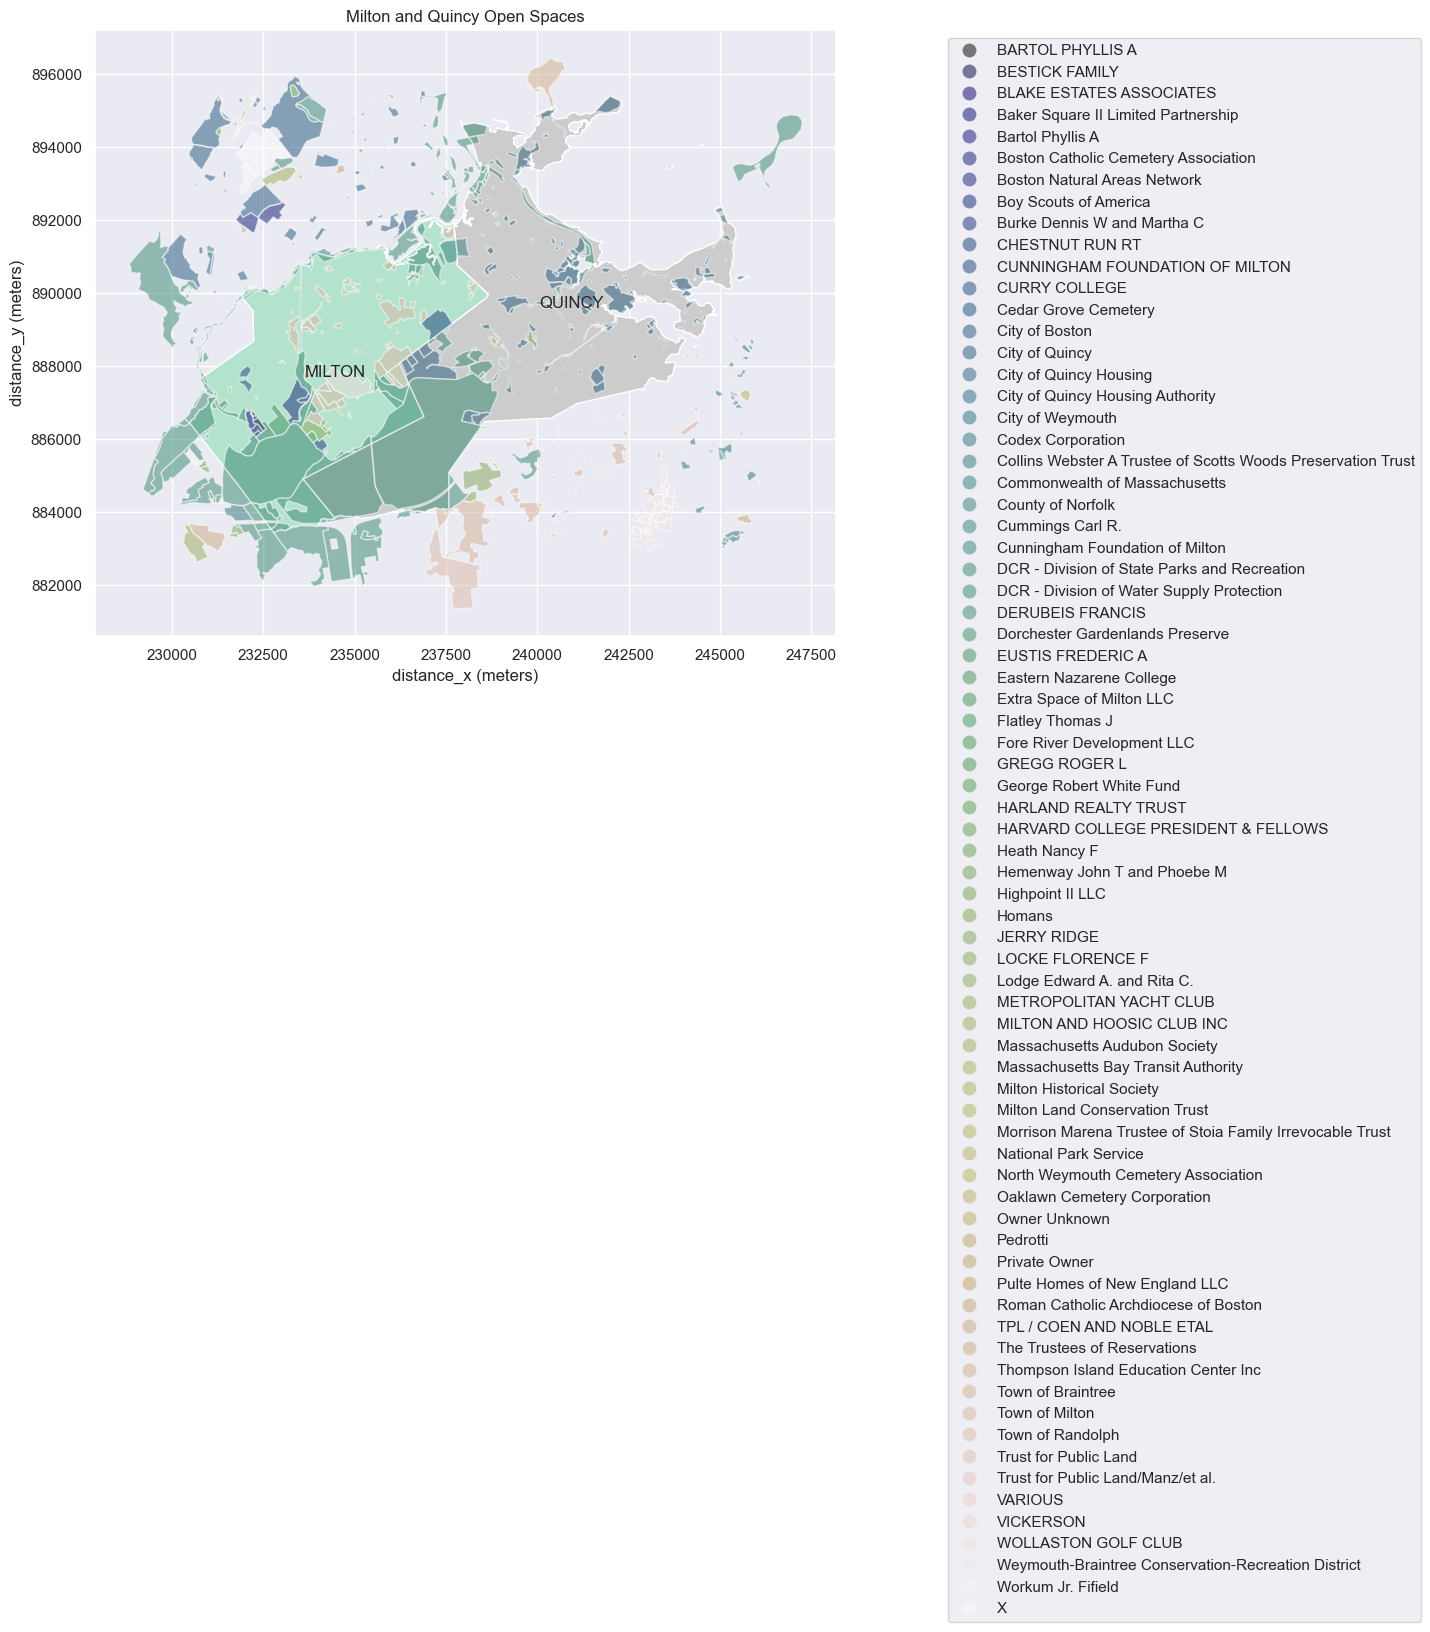

<Figure size 1500x800 with 0 Axes>

In [6]:
mm.plot_map(openspace,
            column="MANAGER",
            ax=ax,
            legend_shift=1.8,
            title="Milton and Quincy Open Spaces",
            alpha=0.5)
display(fig)

Now let's use the `folium` package to plot this data on top of an interactive street map.

In [7]:
map_center = milton_quincy_boundaries.dissolve().centroid.to_crs(epsg=4326)[0]

In [29]:
milton_map = folium.Map(width=800,height=800, location=[map_center.y, map_center.x], zoom_start=12)

sf, cm_dict = mm.make_choropleth_style_function(openspace, "PUB_ACCESS", "Dark2")

#Print a legend
display(Markdown("""**Explorable Map of Open Space**

You can pan and zoom the map below to explore open space in Quincy and Milton.
Click on open space parcels to see a pop-up with more information.
""" + mm.html_legend(cm_dict)))

folium.GeoJson(milton_quincy_boundaries.to_crs("EPSG:3857").geometry).add_to(milton_map)

# We need to convert the openspace geodataframe to the EPSG:3857 coordinate reference system (CRS) because that is the default for folium maps.
folium.GeoJson(data=openspace.to_crs("EPSG:3857"),
               style_function=sf,
               popup=folium.GeoJsonPopup(
                   fields=['SITE_NAME', 'MANAGER', 'GIS_ACRES', "PRIM_PURP", "PUB_ACCESS", "LEV_PROT"],
                   aliases=['Name','Managed by','Acres', "Primary Purpose", "Public Access", "Level of Protection"]
               )).add_to(milton_map)
display(milton_map)


**Explorable Map of Open Space**

You can pan and zoom the map below to explore open space in Quincy and Milton.
Click on open space parcels to see a pop-up with more information.
<table>
  <tr>
    <th>Value</th>
    <th>Color</th>
  </tr>
<tr><td><span style="font-family: monospace">Yes (open to public)</span></td> <td><span style="color: #1b9e77">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Limited (membership only)</span></td> <td><span style="color: #d95f02">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Unknown</span></td> <td><span style="color: #7570b3">████████</span></td></tr>
<tr><td><span style="font-family: monospace">No (not open to public)</span></td> <td><span style="color: #e7298a">████████</span></td></tr></table>

### Calculate distribution of distance to openspace for residential parcels

Finally, let's tackle our question of whether Quincy residents are further from open space on average compared to Milton residents.

Let's first filter the open space parcels down to those that are publicly accessible:

In [9]:
openspace['PUB_ACCESS'].unique()

array(['Yes (open to public)', 'Limited (membership only)', 'Unknown',
       'No (not open to public)'], dtype=object)

In [10]:
accessible_openspace = openspace[openspace['PUB_ACCESS']=="Yes (open to public)"]

The following geopandas spatial join links each residential land parcel to the nearest open space land parcel, using the closest distance between the two shapes.  It can produce multiple output rows per residential land parcel if there are multiple open space parcels that are equidistant with the shortest distance.

In [11]:
result = gpd.sjoin_nearest(residential_tax_parcels, accessible_openspace, how="left", distance_col="distance_to_openspace")
result.head()

SHAPE_Leng    SHAPE_Area MAP_PAR_ID POLY_TYPE MAP_NO  \
LOC_ID                                                                   
189M 2 6                 NaN           NaN        NaN       NaN    NaN   
2436080Q_22_22           NaN           NaN        NaN       NaN    NaN   
F_757603_2907021  718.018773  21213.803766    A 10 1B       FEE      A   
F_757603_2907021  718.018773  21213.803766    A 10 1B       FEE      A   
F_757603_2907021  718.018773  21213.803766    A 10 1B       FEE      A   

                  SOURCE PLAN_ID   LAST_EDIT BND_CHK NO_MATCH  ...  INTSYM  \
LOC_ID                                                         ...           
189M 2 6             NaN     NaN         NaN     NaN      NaN  ...     NaN   
2436080Q_22_22       NaN     NaN         NaN     NaN      NaN  ...     NaN   
F_757603_2907021  ASSESS  A-9-10  20180101.0     NaN        N  ...     NaN   
F_757603_2907021  ASSESS  A-9-10  20180101.0     NaN        N  ...     NaN   
F_757603_2907021  ASSESS  A-9-10  20180101.0     NaN        N  ...     NaN   

                   OS_ID  CAL_DATE_R  FORMAL_SIT CR_REF OS_TYPE EEA_CR_ID  \
LOC_ID                                                                      
189M 2 6             NaN         NaN         NaN    NaN     NaN       NaN   
2436080Q_22_22       NaN         NaN         NaN    NaN     NaN       NaN   
F_757603_2907021  50-173  2019-06-11         NaN    0.0     NaN       NaN   
F_757603_2907021  189-91  2019-06-11         NaN    0.0     NaN       NaN   
F_757603_2907021  189-92  2019-06-11         NaN    0.0     NaN       NaN   

                   SHAPE_AREA   SHAPE_LEN  distance_to_openspace  
LOC_ID                                                            
189M 2 6                  NaN         NaN                    NaN  
2436080Q_22_22            NaN         NaN                    NaN  
F_757603_2907021  1350.764294  155.163256                    0.0  
F_757603_2907021  1218.553710  145.826404                    0.0  
F_757603_2907021  8290.233976  487.599831                    0.0  

[5 rows x 91 columns]

Plot the distribution of distance to the nearest open land for Milton and for Quincy.

It looks like Quincy residents are just as close to the nearest open land as their Milton neighbors, on average.  That's a little surprising!

/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/milton-maps-gfMaDXEA-py3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


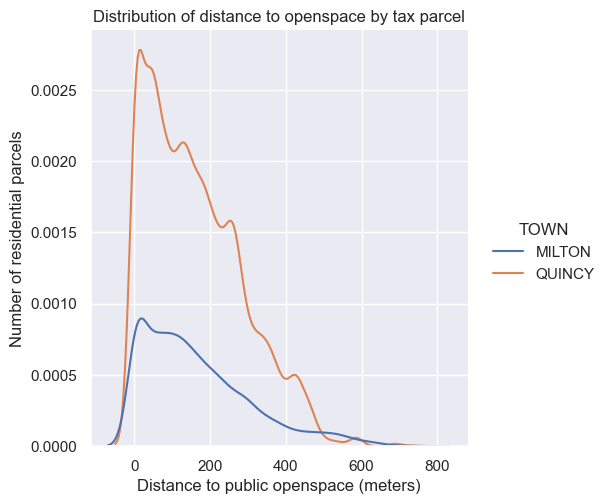

In [12]:
g = sns.displot(result.reset_index(), x='distance_to_openspace', hue="TOWN", kind="kde", common_norm=True)
g.set(xlabel="Distance to public openspace (meters)",
      ylabel="Number of residential parcels",
      title="Distribution of distance to openspace by tax parcel")
plt.show()

Quantifying htis in a table, we see the median Milton residence is 133 meters from the nearest open space, versus 139 meters for Quincy.  Not a big difference!

In [13]:
result.groupby("TOWN")["distance_to_openspace"].quantile([0.1,0.25,0.5,0.75,0.9, 1])

TOWN        
MILTON  0.10      5.712570
        0.25     53.907962
        0.50    133.377918
        0.75    241.847707
        0.90    365.795553
        1.00    765.278952
QUINCY  0.10     10.835055
        0.25     54.520340
        0.50    139.640397
        0.75    245.533747
        0.90    342.402368
        1.00    741.994475
Name: distance_to_openspace, dtype: float64

Can we find any quantitative metric that captures that Milton is a "greener" town than Quincy?  Yes, if we look at the sizes of the nearest open land, then we see a difference:

In [14]:
result.groupby("TOWN")["GIS_ACRES"].quantile([0.1,0.25,0.5,0.75,0.9, 1])

TOWN        
MILTON  0.10       1.123130
        0.25       2.374769
        0.50      10.360659
        0.75      41.058375
        0.90      91.141803
        1.00     850.270058
QUINCY  0.10       0.464241
        0.25       1.019486
        0.50       4.073247
        0.75       8.028349
        0.90      45.769913
        1.00    1753.275872
Name: GIS_ACRES, dtype: float64

While the median Milton residence is no closer to open space than its Quincy counterpart, the median acreage of that open plot is more than twice as large, 10 acres in Milton vs 4 acres in Quincy.

Another random question we can ask of this data: which specific open spaces are the nearest open spaces for the most residence?

In [15]:
result.groupby("SITE_NAME").agg(
    num_houses=('SITE_NAME', 'count'),
    median_distance=('distance_to_openspace', 'median'),
    acreage=('GIS_ACRES', 'max'),
).sort_values(by="num_houses", ascending=False)

num_houses  median_distance      acreage
SITE_NAME                                                                  
Neponset River Reservation               1793        83.156849   109.972767
Furnace Brook Parkway                    1377        56.429668    13.560602
Blue Hills Reservation                   1285        89.716382  1753.275872
Quincy Shore Reservation                 1102       129.058568    70.234147
Mass Field Playground                    1051       273.067339     0.860044
...                                       ...              ...          ...
Beechwood Knoll School Playground          11        43.317348     0.198522
Jean Kennedy Playground                     9       112.574221     0.158380
Lamb Conservation Area                      5       234.870044     7.621469
Brooks Field                                3        58.219847    14.741131
Front - Heron Beach                         2        38.887931     0.380590

[132 rows x 3 columns]

### School Building candidate parcels

The school building committee was looking at open spaces owned by the Town of Milton of at least 6 acres.  Can we see how many of these there are and where they're located?

In [16]:
openspace.loc[openspace.FEE_OWNER.str.lower().str.contains("milton"), "FEE_OWNER"].unique()

array(['Town of Milton', 'Cunningham Foundation of Milton',
       'Milton Historical Society', 'CUNNINGHAM FOUNDATION OF MILTON',
       'Extra Space of Milton LLC', 'MILTON AND HOOSIC CLUB INC',
       'Milton Land Conservation Trust'], dtype=object)

In [17]:
school_site_candidates = openspace[(openspace.FEE_OWNER=="Town of Milton") & (openspace.GIS_ACRES >= 6.0)]
school_site_candidates

TOWN_ID  POLY_ID                            SITE_NAME       FEE_OWNER  \
100      189     3058   Milton High School Athletic Fields  Town of Milton   
101      189       58               Lamb Conservation Area  Town of Milton   
103      189     3131                         Brooks Field  Town of Milton   
107      189     3064                    Turners Pond Park  Town of Milton   
116      189     3132   Pine Tree Brook Flood Control Area  Town of Milton   
136      189     3046                   Milton Town Forest  Town of Milton   
137      189     3121                   Milton Town Forest  Town of Milton   
252      189       55                           Popes Pond  Town of Milton   
276      189       62            Granite Links Golf Course  Town of Milton   
281      189       60            Granite Links Golf Course  Town of Milton   
302      189       51         John L. Kelly Athletic Field  Town of Milton   
339      189     3049                                  NaN  Town of Milton   
375      189     3084                         Andrews Park  Town of Milton   
414      189     3047   Pine Tree Brook Flood Control Area  Town of Milton   
472      189     3123     Arrowhead Lane Conservation Area  Town of Milton   
496      189     3080  Collicot School & Mary A Cunningham  Town of Milton   
501      189     3116                                  Day  Town of Milton   
618      189     3073                      Milton Cemetery  Town of Milton   

    OWNER_ABRV OWNER_TYPE         MANAGER MANAGR_ABR MANAGR_TYP  \
100       M189          M  Town of Milton     M189SD          M   
101       M189          M  Town of Milton     M189CC          M   
103       M189          M  Town of Milton     M189CC          M   
107       M189          M  Town of Milton     M189PD          M   
116       M189          M  Town of Milton        NaN        NaN   
136       M189          M  Town of Milton        NaN        NaN   
137       M189          M  Town of Milton        NaN        NaN   
252       M189          M  Town of Milton     M189CC          M   
276       M189          M  Town of Milton        NaN          P   
281       M189          M  Town of Milton        NaN          P   
302       M189          M  Town of Milton     M189PD          M   
339       M189          M  Town of Milton     M189CC          M   
375       M189          M  Town of Milton     M189PD          M   
414       M189          M  Town of Milton        NaN        NaN   
472       M189          M  Town of Milton     M189CC          M   
496       M189          M  Town of Milton     M189SD          M   
501       M189          M  Town of Milton        NaN        NaN   
618       M189          M  Town of Milton        NaN        NaN   

                                            PRIM_PURP  ... INTSYM     OS_ID  \
100        Recreation (activities are facility based)  ...    NaN  189-3058   
101  Conservation (activities are non-facility based)  ...    NaN    189-58   
103        Recreation (activities are facility based)  ...    NaN  189-3131   
107        Recreation (activities are facility based)  ...    NaN  189-3064   
116                                     Flood Control  ...    NaN  189-3132   
136                                   Other (explain)  ...    NaN  189-3046   
137                                   Other (explain)  ...    NaN  189-3121   
252                       Recreation and Conservation  ...    NaN    189-55   
276        Recreation (activities are facility based)  ...    NaN    189-62   
281        Recreation (activities are facility based)  ...    NaN    189-60   
302        Recreation (activities are facility based)  ...    NaN    189-51   
339  Conservation (activities are non-facility based)  ...    NaN  189-3049   
375        Recreation (activities are facility based)  ...    NaN  189-3084   
414                                     Flood Control  ...    NaN  189-3047   
472  Conservation (activities are non-facility based)  ...    N

In [18]:
milton_boundaries = town_boundaries[town_boundaries.TOWN.isin(["MILTON"])]
map_center = milton_boundaries.dissolve().centroid.to_crs(epsg=4326)[0]

In [19]:
milton_map = folium.Map(width=800,height=800, location=[map_center.y, map_center.x], zoom_start=13)

sf, cm_dict = mm.make_choropleth_style_function(school_site_candidates, "PRIM_PURP", "Dark2")

#Print a legend
display(Markdown("""**Explorable Map of School Site Candidates**

You can pan and zoom the map below to explore school site candidates in Milton.
Click on open space parcels to see a pop-up with more information.
""" + mm.html_legend(cm_dict)))

folium.GeoJson(milton_boundaries.to_crs("EPSG:3857").geometry).add_to(milton_map)

# We need to convert the openspace geodataframe to the EPSG:3857 coordinate reference system (CRS) because that is the default for folium maps.
folium.GeoJson(data=school_site_candidates.to_crs("EPSG:3857"),
               style_function=sf,
               popup=folium.GeoJsonPopup(
                   fields=['SITE_NAME', 'GIS_ACRES', "PRIM_PURP", "PUB_ACCESS", "LEV_PROT", "COMMENTS"],
                   aliases=['Name','Managed by','Acres', "Primary Purpose", "Public Access", "Level of Protection"]
               )).add_to(milton_map)
display(milton_map)


**Explorable Map of School Site Candidates**

You can pan and zoom the map below to explore school site candidates in Milton.
Click on open space parcels to see a pop-up with more information.
<table>
  <tr>
    <th>Value</th>
    <th>Color</th>
  </tr>
<tr><td><span style="font-family: monospace">Recreation (activities are facility based)</span></td> <td><span style="color: #1b9e77">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Conservation (activities are non-facility based)</span></td> <td><span style="color: #d95f02">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Flood Control</span></td> <td><span style="color: #7570b3">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Other (explain)</span></td> <td><span style="color: #e7298a">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Recreation and Conservation</span></td> <td><span style="color: #66a61e">████████</span></td></tr></table>

We can see that many town-owned parcels of the right size have existing recreational facilities or have a flood-control purpose and hence are not suitable for building.  The orange parcels are the remaining sites, and we can see that one of the remaining three is the much discussed Lamb Conservation Area.

### How much openspace does Milton have?  How much is in conservation status?

In [20]:
milton_openspace = openspace.loc[openspace.TOWN_ID==189]
milton_openspace.head()

TOWN_ID  POLY_ID                             SITE_NAME       FEE_OWNER  \
100      189     3058    Milton High School Athletic Fields  Town of Milton   
101      189       58                Lamb Conservation Area  Town of Milton   
102      189     3130  Pierce Middle School Athletic Fields  Town of Milton   
103      189     3131                          Brooks Field  Town of Milton   
104      189     3059              Pine Tree Brook Greenway   Owner Unknown   

    OWNER_ABRV OWNER_TYPE         MANAGER MANAGR_ABR MANAGR_TYP  \
100       M189          M  Town of Milton     M189SD          M   
101       M189          M  Town of Milton     M189CC          M   
102       M189          M  Town of Milton     M189SD          M   
103       M189          M  Town of Milton     M189CC          M   
104        NaN          X   Owner Unknown        NaN        NaN   

                                            PRIM_PURP  ... INTSYM     OS_ID  \
100        Recreation (activities are facility based)  ...    NaN  189-3058   
101  Conservation (activities are non-facility based)  ...    NaN    189-58   
102        Recreation (activities are facility based)  ...    NaN  189-3130   
103        Recreation (activities are facility based)  ...    NaN  189-3131   
104        Recreation (activities are facility based)  ...    NaN  189-3059   

     CAL_DATE_R FORMAL_SIT CR_REF OS_TYPE EEA_CR_ID    SHAPE_AREA  \
100         NaN        NaN      0     NaN       NaN  57890.235319   
101  1978-12-15        NaN      0     NaN       NaN  30842.988911   
102         NaN        NaN      0     NaN       NaN   9610.348045   
103  1978-12-15        NaN      0     NaN       NaN  59655.241145   
104         NaN        NaN      0     NaN       NaN   4865.273125   

       SHAPE_LEN                                           geometry  
100   971.136985  POLYGON ((234089.437 889234.177, 234044.386 88...  
101  1239.561577  POLYGON ((233571.280 889147.018, 233560.965 88...  
102   453.437248  POLYGON ((234292.207 889748.966, 234286.572 88...  
103  1196.681131  POLYGON ((233866.667 888929.914, 233847.029 88...  
104  1608.666884  POLYGON ((233552.836 889220.870, 233552.322 88...  

[5 rows x 62 columns]

In [21]:
openspace.TOWN_ID.unique()

array([243, 189, 336,  40,  35, 244,  50, 142,  73])

In [22]:
milton_openspace.PRIM_PURP.value_counts()

PRIM_PURP
Recreation and Conservation                         47
Conservation (activities are non-facility based)    44
Recreation (activities are facility based)          31
Other (explain)                                      7
Historical/Cultural                                  7
Agricultural                                         6
Flood Control                                        2
Name: count, dtype: int64

In [23]:
milton_map = folium.Map(width=800,height=800, location=[map_center.y, map_center.x], zoom_start=12)

sf, cm_dict = mm.make_choropleth_style_function(openspace, "PRIM_PURP", "Dark2")

#Print a legend
display(Markdown("""**Explorable Map of Open Space**

You can pan and zoom the map below to explore open space in Quincy and Milton.
Click on open space parcels to see a pop-up with more information.
""" + mm.html_legend(cm_dict)))

folium.GeoJson(milton_quincy_boundaries.to_crs("EPSG:3857").geometry).add_to(milton_map)

# We need to convert the openspace geodataframe to the EPSG:3857 coordinate reference system (CRS) because that is the default for folium maps.
folium.GeoJson(data=milton_openspace.to_crs("EPSG:3857"),
               style_function=sf,
               popup=folium.GeoJsonPopup(
                   fields=['SITE_NAME', 'MANAGER', 'GIS_ACRES', "PRIM_PURP", "PUB_ACCESS", "LEV_PROT"],
                   aliases=['Name','Managed by','Acres', "Primary Purpose", "Public Access", "Level of Protection"]
               )).add_to(milton_map)
display(milton_map)


**Explorable Map of Open Space**

You can pan and zoom the map below to explore open space in Quincy and Milton.
Click on open space parcels to see a pop-up with more information.
<table>
  <tr>
    <th>Value</th>
    <th>Color</th>
  </tr>
<tr><td><span style="font-family: monospace">Recreation (activities are facility based)</span></td> <td><span style="color: #1b9e77">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Conservation (activities are non-facility based)</span></td> <td><span style="color: #d95f02">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Flood Control</span></td> <td><span style="color: #7570b3">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Historical/Cultural</span></td> <td><span style="color: #e7298a">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Water Supply Protection</span></td> <td><span style="color: #66a61e">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Site is underwater</span></td> <td><span style="color: #e6ab02">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Recreation and Conservation</span></td> <td><span style="color: #a6761d">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Other (explain)</span></td> <td><span style="color: #666666">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Agricultural</span></td> <td><span style="color: #666666">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Unknown</span></td> <td><span style="color: #666666">████████</span></td></tr></table>

In [24]:
conservation_land_purposes = [
    'Conservation (activities are non-facility based)',
    'Recreation and Conservation',
]
conservation_area = milton_openspace.loc[milton_openspace.PRIM_PURP.isin(conservation_land_purposes), "SHAPE_AREA"].sum()

In [25]:
conservation_area

10017849.02254728

In [26]:
milton_openspace.crs

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [27]:
SQ_METERS_PER_ACRE = 4046.86

In [28]:
conservation_area / SQ_METERS_PER_ACRE

2475.4622157789695